# DiagVI for integration of spatial and dissociated data
This tutorial demonstrates how to use scviGLUE for integrating spatial and dissociated single-cell datasets.

To run this notebook, follow the instructions in the `README.md`.

## Preliminaries
### Import packages and data

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import squidpy as sq

from scvi.external import DIAGVI

warnings.filterwarnings("ignore")

In [41]:
sc.settings.set_figure_params(scanpy=True, frameon=False, fontsize=10)

### Load Data
We load two datasets as separate AnnData objects. Both datasets profile mouse organogenesis at approximately embryonic day 8.5 (E8.5).

In [42]:
ad_sp = sc.read(
    "data/spatial_data.h5ad", backup_url="https://figshare.com/ndownloader/files/54145250"
)
ad_sp

AnnData object with n_obs × n_vars = 51787 × 351
    obs: 'embryo', 'pos', 'z', 'embryo_pos', 'embryo_pos_z', 'Area', 'celltype_seqfish', 'sample_seqfish', 'umap_density_sample', 'modality', 'total_counts', 'n_counts', 'celltype_harmonized'
    uns: 'celltype_harmonized_colors', 'celltype_seqfish_colors', 'embryo_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_orig', 'spatial'
    varm: 'PCs'

In [43]:
ad_diss = sc.read(
    "data/dissociated_data.h5ad", backup_url="https://figshare.com/ndownloader/files/54145217"
)
ad_diss

AnnData object with n_obs × n_vars = 16496 × 18499
    obs: 'barcode', 'sample_rna', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype_rna', 'haem_subclust', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutDPT', 'endo_gutCluster', 'sizefactor', 'modality', 'total_counts', 'n_counts', 'celltype_harmonized'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_harmonized_colors', 'celltype_rna_colors', 'cluster_colors', 'hvg', 'pca', 'sample_colors', 'sequencing.batch_colors', 'stage_colors', 'theiler_colors', 'umap'
    obsm: 'X_endo_gephi', 'X_endo_gut', 'X_haem_gephi', 'X_pca', 'X_umap', 'X_umap_orig'
    varm: 'PCs'

### Basic preprocessing

In [44]:
ad_sp.layers["counts"] = ad_sp.X.copy()
ad_sp.var["original_feature_name"] = ad_sp.var.index.copy()

sc.pp.normalize_total(ad_sp, target_sum=1e4)
sc.pp.log1p(ad_sp)

In [45]:
ad_diss.layers["counts"] = ad_diss.X.copy()
ad_diss.var["original_feature_name"] = ad_diss.var.index.copy()

sc.pp.normalize_total(ad_diss, target_sum=1e4)
sc.pp.log1p(ad_diss)
sc.pp.highly_variable_genes(ad_diss)

print(f"This computed {ad_diss.var['highly_variable'].sum()} highly variable genes")

This computed 1677 highly variable genes


Subset the dissociated data to the union of highly variable and spatially measured genes.

In [46]:
genes_diss = ad_sp.var_names.union(ad_diss.var.query("highly_variable").index).intersection(
    ad_diss.var_names
)
ad_diss = ad_diss[:, genes_diss].copy()

Print final data dimensions

In [47]:
print(f"Spatial data dimensions: {ad_sp.shape}")
print(f"Dissociated data dimensions: {ad_diss.shape}")

Spatial data dimensions: (51787, 351)
Dissociated data dimensions: (16496, 1780)


### Basic visualization

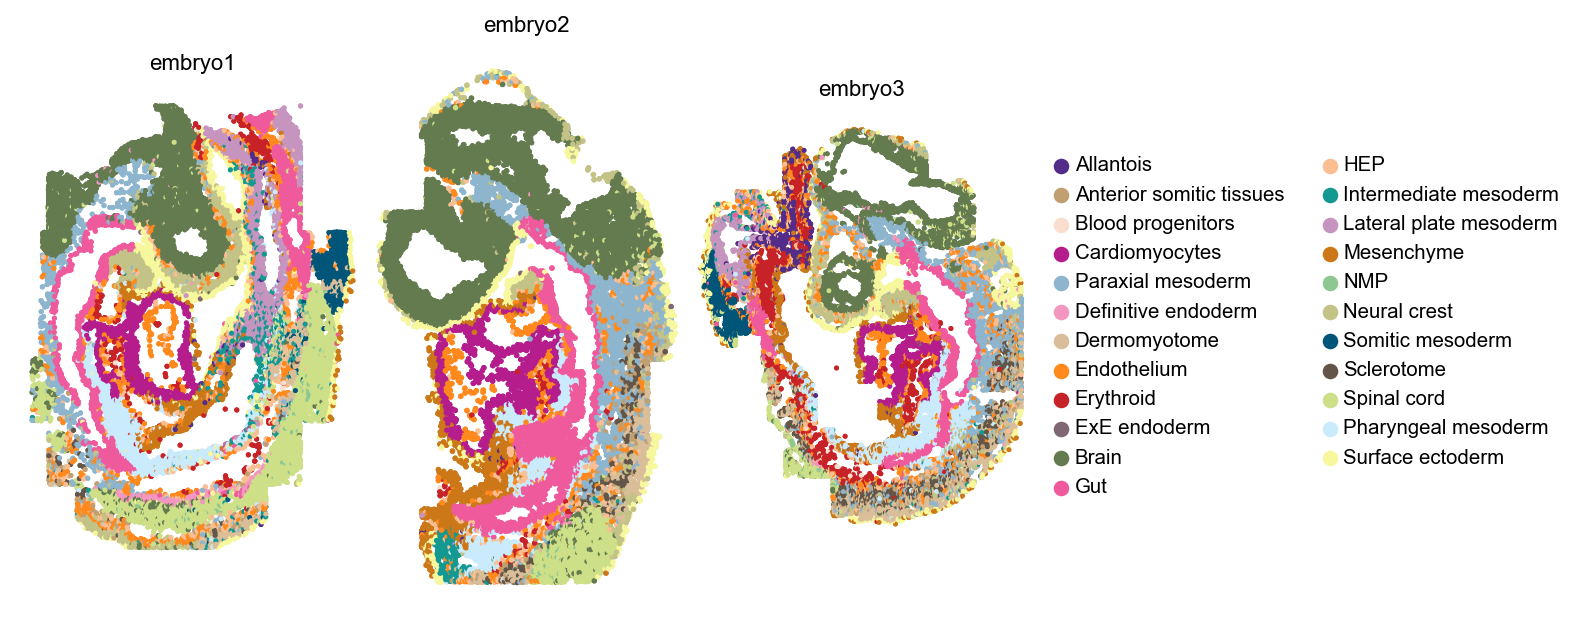

In [48]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    keys = ad_sp.obs["embryo"].cat.categories

    _, axes = plt.subplots(1, len(keys), figsize=(len(keys) * 2 + 4, 4))

    for i, (ax, cat) in enumerate(zip(axes, keys, strict=True)):
        obs_mask = ad_sp.obs["embryo"] == cat
        sq.pl.spatial_scatter(
            ad_sp[obs_mask],
            ax=ax,
            color="celltype_harmonized",
            title=cat,
            shape=None,
            library_id=None,
            legend_loc="right margin" if i == len(keys) - 1 else "none",
        )

    plt.tight_layout()

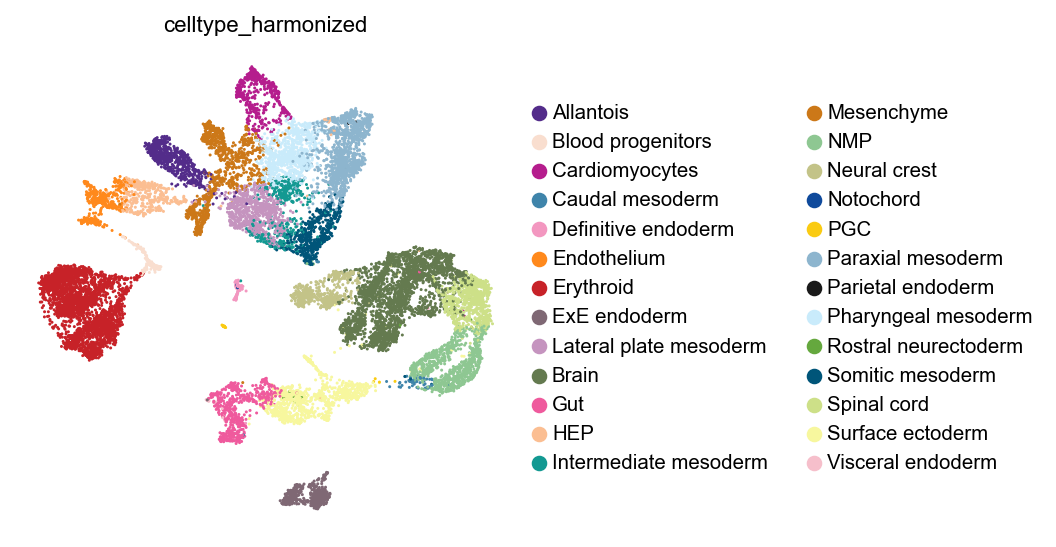

In [49]:
sc.pl.embedding(ad_diss, basis="X_umap", color="celltype_harmonized")

## Prepare and train the model
### Configure both AnnData objects
- **`layer`**: Specifies which layer of the AnnData object to use as input data (e.g., `"counts"` for raw counts).
- **`batch_key`**: Indicates the column in `.obs` containing batch information to condition on (e.g., `"sample_rna"` or `"embryo"`).
- **`likelihood`**: Sets the likelihood function used to reconstruct the counts (e.g., `"nb"` for negative binomial, `"zinb"` for zero-inflated negative binomial).
- **`labels_key`**: Specifies the column in `.obs` containing cell type labels for semi-supervised learning.
- **`modality`**: Defines the modality type (e.g., `"rna"` or `"protein"`).
- **`gmm_prior`**: Determines whether to use a Gaussian Mixture Model prior for the latent space.
- **`semi_supervised`**: Enables semi-supervised classification if set to `True`.
- **`n_mixture_components`**: Sets the number of mixture components for the GMM prior (if used).
- **`unlabeled_category`**: Specifies the category name for unlabeled cells in `labels_key`.

**Example setup:**

In [50]:
DIAGVI.setup_anndata(ad_diss, layer="counts", batch_key="sample_rna", likelihood="nb")

DIAGVI.setup_anndata(ad_sp, layer="counts", batch_key="embryo", likelihood="nb")

## Construct the Guidance Graph
If not manually constructed, the guidance graph is built automatically upon model initialization (overlapping feature names are connected). 
For manuyl guidance grah construction, we need to provide a `pandas.DataFrame` with two columns, which specifies feature correspondences between modalities. Each column has to correspond to a key in `input_dict`.

In [51]:
input_dict = {"scRNAseq": ad_diss, "seqFISH": ad_sp}

In [52]:
# in our case, the intersecting genes are connected in the guidance graph
intersecting_genes = ad_sp.var_names.intersection(ad_diss.var_names)
correspondence = pd.DataFrame({"seqFISH": intersecting_genes, "scRNAseq": intersecting_genes})

correspondence.head()

seqFISH scRNAseq
0    Abcc4    Abcc4
1     Acp5     Acp5
2    Acvr1    Acvr1
3   Acvr2a   Acvr2a
4  Adora2b  Adora2b

In [53]:
guidance_graph = DIAGVI.construct_custom_guidance_graph(input_dict, correspondence)

### Initialize the model
- **`adatas`**:  
  Dictionary mapping modality names to their respective AnnData objects.  
  Each key is a string identifier for the modality (e.g., `"scRNAseq"` for dissociated data, `"seqFISH"` for spatial data), and each value is an AnnData object containing the data for that modality.

- **`common_scale`** (optional):  
  If set to `True`, enforces a shared scale parameter across modalities in the decoder.

- **`guidance_graph`** (optional):  
  Precomputed guidance graph for feature correspondences. If not provided, it will be constructed automatically.


In [54]:
model = DIAGVI(adatas=input_dict, guidance_graph=guidance_graph)

INFO     Guidance graph consistency checks passed.                                                                 


### Train the model
- **`max_epochs`**:  
  Maximum number of training epochs to run.

- **`batch_size`**:  
  Number of samples per batch during training.

- **`accelerator`**:  
  Device to use for training (e.g., `"mps"` for Apple Silicon).

- **`plan_kwargs`**:  
  Dictionary of additional training parameters:
  - **`lam_kl`**: Weight for the KL divergence term in the loss.
  - **`lam_data`**: Weight for the data reconstruction loss term.
  - **`lam_graph`**: Weight for the guidance graph loss term.
  - **`lam_sinkhorn`**: Weight for the Sinkhorn (optimal transport) loss term.
  - **`lam_class`**: Weight for the classification loss term (if using semi-supervised learning).
  - **`sinkhorn_p`**: Exponent parameter for the Sinkhorn loss.
  - **`sinkhorn_blur`**: Blur parameter for the Sinkhorn loss (controls regularization).


In [55]:
model.train(
    max_epochs=30,
    batch_size=256,
    accelerator="mps",
    plan_kwargs={
        "lam_kl": 1,
        "lam_data": 0.1,
        "lam_graph": 10.0,
        "lam_sinkhorn": 40,
        "lam_class": 0,
        "sinkhorn_p": 1,
        "sinkhorn_blur": 1,
        "sinkhorn_reach": 1,
    },
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/30 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


## Evaluate the trained model
### Retrieve the joint embedding and visualize via UMAP

In [56]:
latents = model.get_latent_representation()

In [57]:
emb_key = "X_diagvi"

ad_diss.obsm[emb_key] = latents["scRNAseq"]
ad_sp.obsm[emb_key] = latents["seqFISH"]

In [58]:
combined = sc.concat([ad_diss, ad_sp], axis=0, join="inner")

In [59]:
# take care of the colors
colors_diss = dict(
    zip(
        ad_diss.obs["celltype_harmonized"].cat.categories,
        ad_diss.uns["celltype_harmonized_colors"],
        strict=False,
    )
)
colors_sp = dict(
    zip(
        ad_sp.obs["celltype_harmonized"].cat.categories,
        ad_sp.uns["celltype_harmonized_colors"],
        strict=False,
    )
)

color_lookup = colors_diss | colors_sp
combined.uns["celltype_harmonized_colors"] = [
    color_lookup[cat] for cat in combined.obs["celltype_harmonized"].cat.categories
]

In [60]:
### compute and show embeddings function
key_added_umap = "X_umap_diagvi"

sc.pp.neighbors(combined, use_rep=emb_key, metric="cosine")
sc.tl.umap(combined, key_added=key_added_umap)

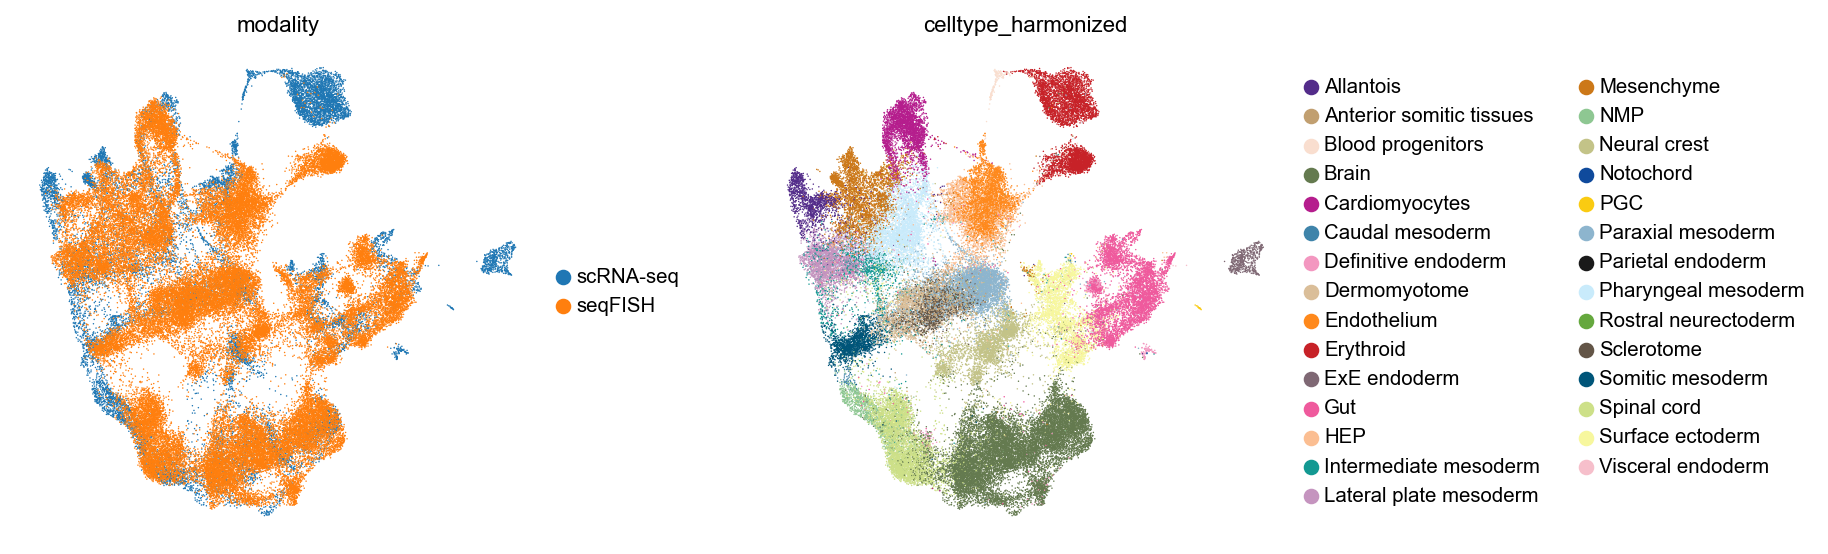

In [61]:
sc.pl.embedding(
    combined,
    basis="umap_diagvi",
    color=[
        "modality",
        "celltype_harmonized",
    ],
    wspace=0.3,
)

### Examine Gene Imputation
Import additional cellmapper dependency

In [62]:
from cellmapper import CellMapper

The `source_name` argument refers to the name of the AnnData object in the dictionary provided upon model initialization. In our case, we set `source_name` to `seqFISH` that we want to infer gene expression values for the spatial dataset.

In [63]:
imputed_values, scores = model.get_imputed_values(source_name="seqFISH", source_adata=ad_sp)

Next, we use [cellmapper](https://cellmapper.readthedocs.io/en/latest/) to evaluate the imputed values. To do this, we initialize a `CellMapper` object, setting the dissociated data as the reference and the spatial data as the query. We then assign the imputed values to the query_imputed attribute of the object:

In [ ]:
# return to original feature names for evaluation with cellmapper
# (requires overlapping feature names)
ad_sp.var_names = ad_sp.var["original_feature_name"]
ad_diss.var_names = ad_diss.var["original_feature_name"]

In [65]:
cmap = CellMapper(query=ad_sp, reference=ad_diss)
cmap.query_imputed = imputed_values

cmap

INFO     Initialized CellMapper with 51787 query cells and 16496 reference cells.                                  
INFO     Imputed expression matrix with shape (51787, 1780) converted to AnnData object.                           
         Observation metadata from query and feature metadata from reference were linked (not copied).             


CellMapper(query=AnnData(n_obs=51,787, n_vars=351), reference=AnnData(n_obs=16,496, n_vars=1,780)

Now, we evaluate the agreement between the original and imputed expression values:

In [66]:
cmap.evaluate_expression_transfer(layer_key="counts", groupby="embryo")

INFO     Expression transfer evaluation (pearson): average value = 0.5093 (n_shared_genes=350, n_test_genes=350)   
INFO     Metrics per group defined in `query.obs['embryo']` computed and stored in `query.varm['metric_pearson']`  


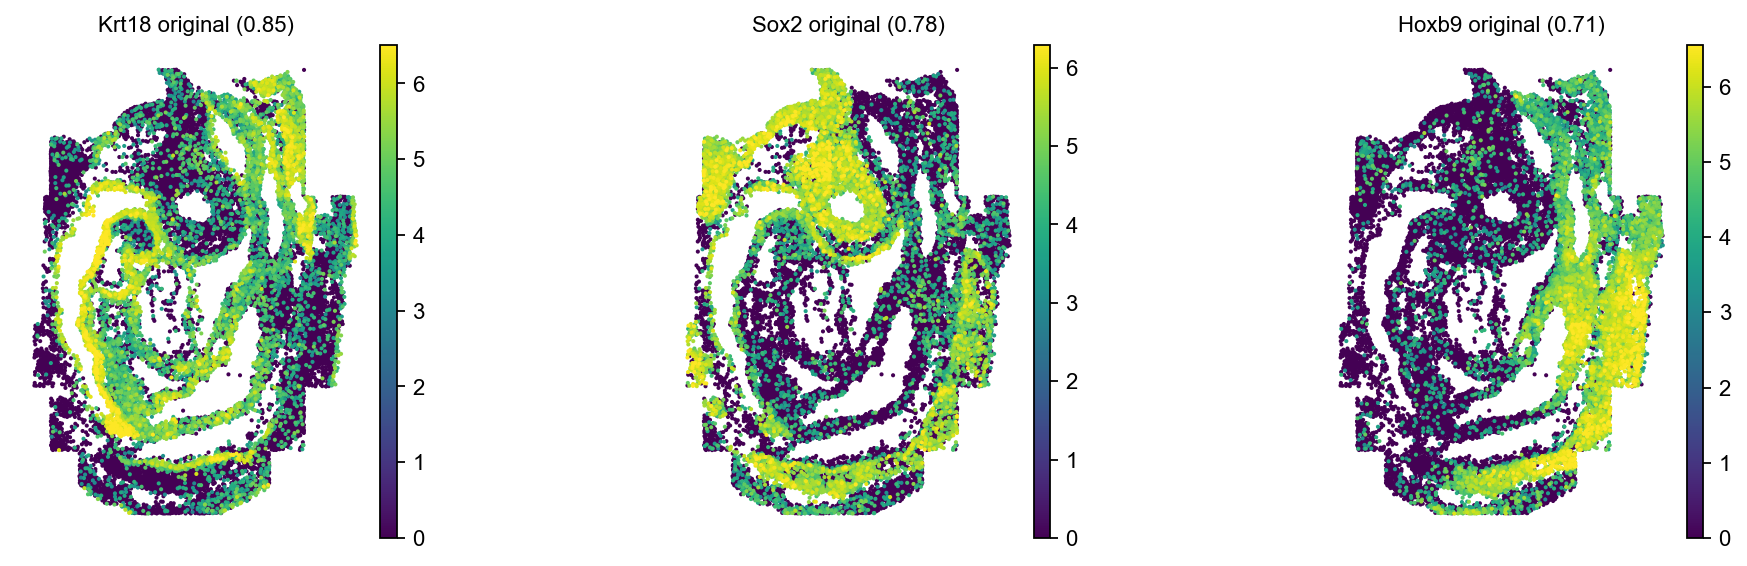

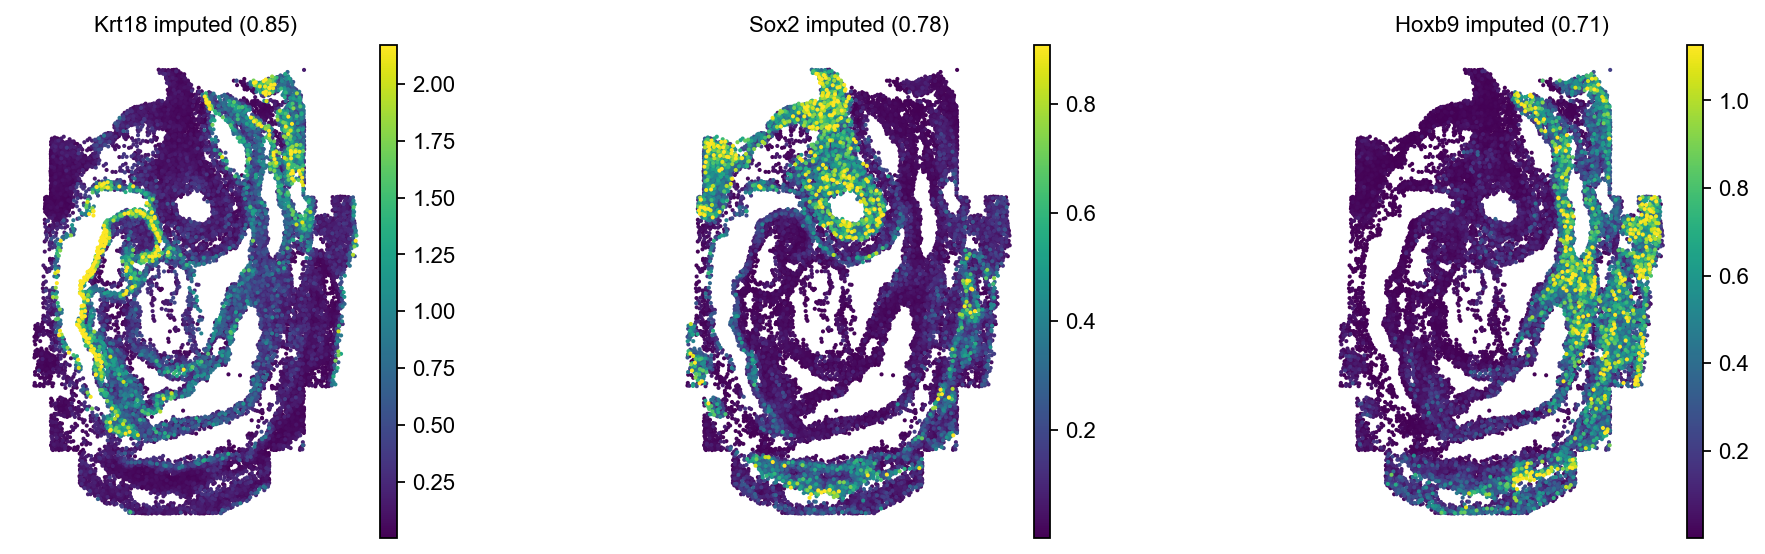

In [67]:
obs_mask = ad_sp.obs["embryo"] == "embryo1"
gene_names = ["Krt18", "Sox2", "Hoxb9"]
gene_corrs = ad_sp.var.loc[gene_names]["metric_pearson"].values

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for adata, key in zip(
        [ad_sp[obs_mask], cmap.query_imputed[obs_mask]], ["original", "imputed"], strict=False
    ):
        sc.pl.spatial(
            adata,
            spot_size=1,
            color=gene_names,
            title=[
                f"{name} {key} ({corr:.2f})"
                for name, corr in zip(gene_names, gene_corrs, strict=False)
            ],
            ncols=len(gene_names),
            size=2,
            vmax="p99",
        )

### Perform label transfer

In [68]:
cmap = CellMapper(query=ad_sp, reference=ad_diss)
cmap.compute_neighbors(use_rep="X_diagvi")

INFO     Initialized CellMapper with 51787 query cells and 16496 reference cells.                                  
WARNING  Using sklearn for neighbor search with large dataset (16496 cells). Consider using approximate k-NN search
         (e.g. pynndescent) or GPU acceleration (e.g. faiss or rapids)                                             
INFO     Using sklearn to compute 30 neighbors.                                                                    


In [69]:
cmap.compute_mapping_matrix()
cmap.map_obs("celltype_harmonized")

INFO     Computing mapping matrix using kernel method 'gauss'.                                                     
INFO     Mapping categorical data for key 'celltype_harmonized' using direct multiplication.                       
INFO     Categorical data mapped and stored in query.obs['celltype_harmonized_pred'].                              


In [70]:
cmap.evaluate_label_transfer(label_key="celltype_harmonized")

INFO     Accuracy: 0.6960, Precision: 0.7199, Recall: 0.6960, Weighted F1-Score: 0.6830, Macro F1-Score: 0.4679,   
         Excluded Fraction: 0.0000                                                                                 


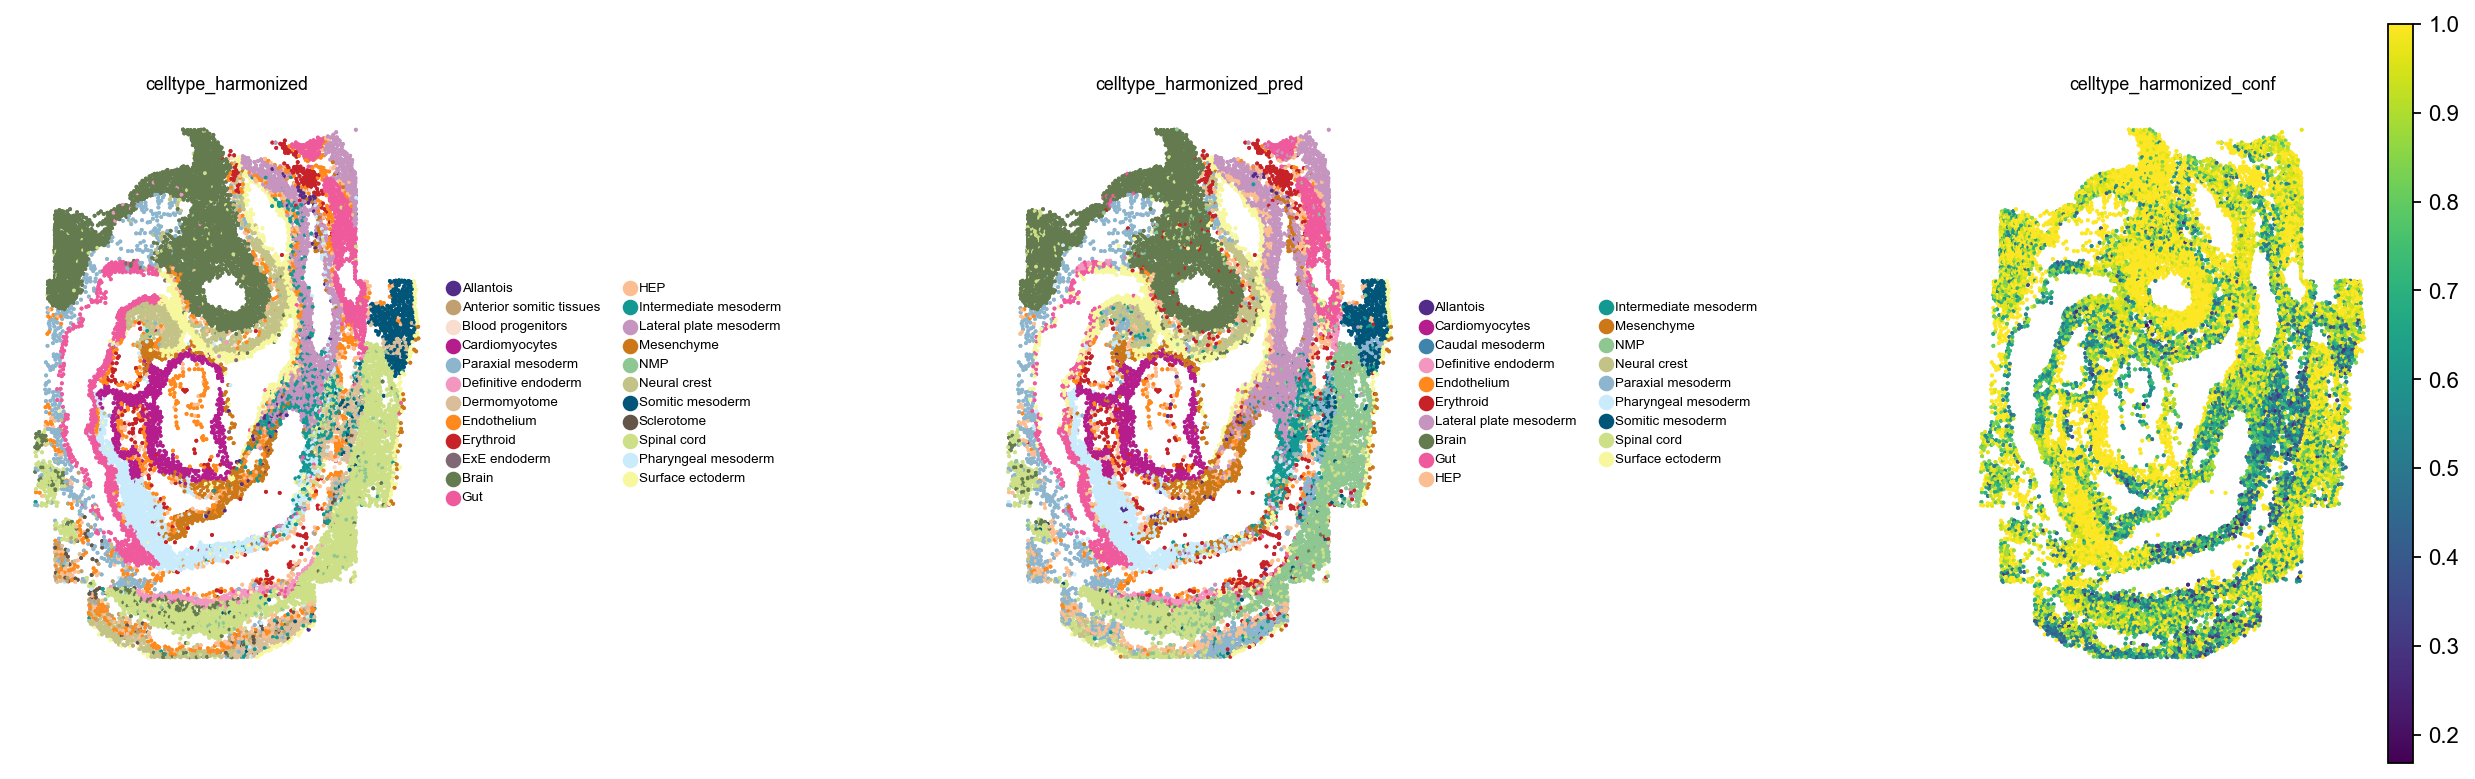

In [71]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    with plt.rc_context({"figure.figsize": (3, 6), "legend.fontsize": 6, "axes.titlesize": 8}):
        sq.pl.spatial_scatter(
            ad_sp,
            color=["celltype_harmonized", "celltype_harmonized_pred", "celltype_harmonized_conf"],
            library_key="embryo",
            library_id="embryo1",
            shape=None,
            wspace=1.1,
        )